+ [Инструкция](https://docs.google.com/document/u/1/d/1aCquhIqsUApgsxQ8-SQBAigFDcfWVVohLEXcV6jWbdI/pub)
+ [kaggle: Udacity AB Testing by Google](https://www.kaggle.com/code/zacksshen/udacity-ab-testing-by-google)
+ [kaggle: AB_Tests_with_Python](https://www.kaggle.com/code/tammyrotem/ab-tests-with-python/notebook)

# Обзор эксперимента: бесплатная пробная версия

Курсы имеют две опции на странице обзора курса: 
+ «начать бесплатную пробную версию» 
+ «доступ к материалам курса»

**Изменение** - если студент нажимал «Начать бесплатную пробную версию», его спрашивали, сколько времени он может посвятить курсу. Если указывал меньшее время, чем требуется, то ему предлагалось выбрать вторую опцию «доступ к материалам курса»

**Гипотеза** заключалась в том, что это могло бы заранее установить более четкие ожидания для пользователей, тем самым уменьшив количество разочарованных студентов, которые бросили бесплатную пробную версию, потому что у них не было достаточно времени.

**Unit of diversion** - cookie, если студент взял бесплатную пробную версию, то user id

![Пример изменения](img/Final_Project_Experiment_Screenshot.png)



# Выбор метрики

+ **Количество файлов cookie**: количество уникальных файлов cookie для просмотра страницы обзора курса. (дмин=3000)
+ **Количество идентификаторов пользователей**: количество пользователей, подписавшихся на бесплатную пробную версию. (дмин=50)
+ **Количество кликов**: то есть количество уникальных файлов cookie для нажатия кнопки «Начать бесплатную пробную версию» (что происходит до срабатывания функции проверки бесплатной пробной версии). (дмин=240)
+ **Вероятность клика**: количество уникальных файлов cookie для нажатия кнопки «Начать бесплатную пробную версию», разделенное на количество уникальных файлов cookie для просмотра страницы обзора курса. (dмин=0,01)
+ **Валовая конверсия**: количество идентификаторов пользователей для завершения оформления заказа и регистрации в бесплатной пробной версии, разделенное на количество уникальных файлов cookie для нажатия кнопки «Начать бесплатную пробную версию». (dмин= 0,01)
+ **Удержание**: количество идентификаторов пользователей, которые должны оставаться зарегистрированными после 14-дневной границы (и, таким образом, совершить хотя бы один платеж), разделенное на количество идентификаторов пользователей для завершения оформления заказа. (dмин=0,01)
+ **Чистая конверсия**: количество идентификаторов пользователей, которые останутся зарегистрированными после 14-дневной границы (и, таким образом, совершят хотя бы один платеж), разделенное на количество уникальных файлов cookie, чтобы нажать кнопку «Начать бесплатную пробную версию». (dмин = 0,0075)

![funnel](img/funnel.png)

1. Инвариантные
    + Количество файлов cookie
    + Количество кликов
    + Вероятность клика
2. Измерительные
    + Валовая конверсия
    + Удержание
    + Чистая конверсия

# Измерение стандартной ошибки (se)

*Совет 1*: Убедитесь, что вы используете только информацию, приведенную в таблице базовых значений. Не используйте результаты эксперимента, так как этот шаг необходимо выполнить до запуска эксперимента.

*Совет 2*. Убедитесь, что вы выяснили, сколько единиц анализа будет соответствовать 5000 просмотрам страниц для каждой метрики. Опять же, используйте заданные базовые значения.

 $$SE = \sqrt{\frac{p(1-p)}{n}}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Даны исходные значения метрик

In [2]:
baseline = pd.read_excel('data/Final Project Baseline Values.xlsx',
                         index_col=0, header=None, 
                         names=['Metric Name', 'Value']
                        )
baseline["MDE"] = [3000, 240, 50, 0.01, 0.01, 0.01, 0.0075]
baseline

,Value,MDE
Metric Name,,
Unique cookies to view course overview page per day:,40000.000000,3000.0000
"Unique cookies to click ""Start free trial"" per day:",3200.000000,240.0000
Enrollments per day:,660.000000,50.0000
"Click-through-probability on ""Start free trial"":",0.080000,0.0100
"Probability of enrolling, given click:",0.206250,0.0100
"Probability of payment, given enroll:",0.530000,0.0100
"Probability of payment, given click",0.109313,0.0075


In [3]:
scale = 5000 / 40_000

eval_metric = baseline.iloc[-3:].copy()
eval_metric.index = ["Валовая конверсия", "Удержание", "Чистая конверсия"]
eval_metric["n"] = np.array([3200, 660, 3200]) * scale
eval_metric["se"] = round(np.sqrt(eval_metric["Value"] * (1 - eval_metric["Value"]) / eval_metric['n']), 4)
eval_metric

,Value,MDE,n,se
Валовая конверсия,0.206250,0.0100,400.0,0.0202
Удержание,0.530000,0.0100,82.5,0.0549
Чистая конверсия,0.109313,0.0075,400.0,0.0156


# Выбор размера выборок с учетом мощности

In [4]:
alpha = 0.05
beta = 0.2

Определить требуемое кол-во просмотров страницы:
+ По [калькулятору](https://www.evanmiller.org/ab-testing/sample-size.html)
посчитали размер выборок
+ Домножили на маштабируемый коэффициент для *Просмотр страницы*
+ Умножили на 2, так как две выборки: A и B

In [5]:
eval_metric['sample_size'] = [25_835, 39_115, 27_563]
eval_metric['pageviews'] = eval_metric['sample_size'] * np.array([40000 / 3200, 40000 / 660, 40000 / 3200])
eval_metric['pageviews'] = eval_metric['pageviews'] * 2
eval_metric

,Value,MDE,n,se,sample_size,pageviews
Валовая конверсия,0.206250,0.0100,400.0,0.0202,25835,6.458750e+05
Удержание,0.530000,0.0100,82.5,0.0549,39115,4.741212e+06
Чистая конверсия,0.109313,0.0075,400.0,0.0156,27563,6.890750e+05


In [6]:
print(f"Требуемое количество просмотров: {round(eval_metric['pageviews'].max()):,}")

Требуемое количество просмотров: 4,741,212


# Продолжительность

In [7]:
fraq = 1
eval_metric['duration'] = np.ceil(eval_metric['pageviews'] / (40_000 * fraq))
eval_metric

,Value,MDE,n,se,sample_size,pageviews,duration
Валовая конверсия,0.206250,0.0100,400.0,0.0202,25835,6.458750e+05,17.0
Удержание,0.530000,0.0100,82.5,0.0549,39115,4.741212e+06,119.0
Чистая конверсия,0.109313,0.0075,400.0,0.0156,27563,6.890750e+05,18.0


In [8]:
print("Процент трафика для эксперимента: 100%")
print("Продолжительность эксперимента: 18 дней")

Процент трафика для эксперимента: 100%
Продолжительность эксперимента: 18 дней


**Удержание** не сможем проанализировать, так как для него нужно значительно больше времени

# Анализ

In [9]:
df_A = pd.read_excel("data/Final Project Results.xlsx", sheet_name="Control")
df_A.head()

,Date,Pageviews,Clicks,Enrollments,Payments
0,"Sat, Oct 11",7723,687,134.0,70.0
1,"Sun, Oct 12",9102,779,147.0,70.0
2,"Mon, Oct 13",10511,909,167.0,95.0
3,"Tue, Oct 14",9871,836,156.0,105.0
4,"Wed, Oct 15",10014,837,163.0,64.0


In [10]:
df_B = pd.read_excel("data/Final Project Results.xlsx", sheet_name="Experiment")
df_B.head()

,Date,Pageviews,Clicks,Enrollments,Payments
0,"Sat, Oct 11",7716,686,105.0,34.0
1,"Sun, Oct 12",9288,785,116.0,91.0
2,"Mon, Oct 13",10480,884,145.0,79.0
3,"Tue, Oct 14",9867,827,138.0,92.0
4,"Wed, Oct 15",9793,832,140.0,94.0


## Проверка работоспособности эксперимента

In [11]:
from scipy import stats

In [188]:
def plot_ci_interval(observed, error, h_0, mde=None, name=''):
    fig, ax = plt.subplots(figsize=(6, 1))
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    
    ax.errorbar(x=observed, y=name, xerr=error, fmt='o', color='orange',
                ecolor='lightgreen', elinewidth=5, capsize=20, capthick=2)
    ax.axvline(h_0, color='red', ls='--')

    y_max = ax.get_ylim()[1]
    y = y_max + 0.2 * y_max
    ax.text(h_0, y, 'H0', ha='center', weight='bold')
    
    if mde:
        mde = -mde if observed < h_0 else mde
        ax.axvline(mde, ls='--')
        ax.text(mde, y, 'MDE', ha='center', weight='bold')
    

`stats.norm.ppf(0.975)` - вернёт z-значение для 97.5% вероятности

In [12]:
stats.norm.ppf(0.975)

1.959963984540054

### Количество просмотров и кликов

1. Разделение на группы сделано рандомным с вероятностью 50%
2. Сравнить наблюдаемую долю с ожидаемой 0.5 исходя из биноминального-нормального распределения

In [42]:
p = 0.5
alpha = 0.05

df_ivariant = pd.DataFrame({"A": df_A.iloc[:, 1:3].sum(),
                            "B": df_B.iloc[:, 1:3].sum()}
                           )
df_ivariant["total"] = df_ivariant["A"] + df_ivariant["B"]
df_ivariant["p"] = p
df_ivariant["se"] = np.sqrt(p * (1 - p) / df_ivariant["total"])
df_ivariant["error"] = stats.norm.ppf(1-alpha/2) * df_ivariant["se"]
df_ivariant["CI_lower"] = df_ivariant["p"] - df_ivariant["error"]
df_ivariant["CI_upper"] = df_ivariant["p"] + df_ivariant["error"]
df_ivariant["Observed_A"] = df_ivariant["A"] / df_ivariant["total"]
df_ivariant["pass"] = ((df_ivariant["CI_lower"] <= df_ivariant["Observed_A"]) 
                       & (df_ivariant["Observed_A"] <= df_ivariant["CI_upper"]))
df_ivariant.round(4)

,A,B,total,p,se,error,CI_lower,CI_upper,Observed_A,pass
Pageviews,345543,344660,690203,0.5,0.0006,0.0012,0.4988,0.5012,0.5006,True
Clicks,28378,28325,56703,0.5,0.0021,0.0041,0.4959,0.5041,0.5005,True


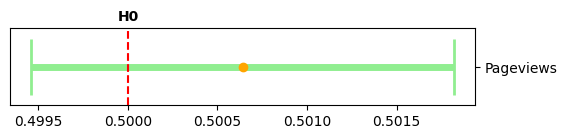

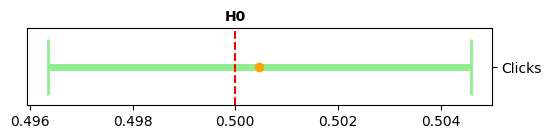

In [189]:
for metric in ["Pageviews", "Clicks"]:
    val = df_ivariant.loc[metric]
    plot_ci_interval(observed=val["Observed_A"], 
                     error=val["error"], 
                     h_0=0.5, 
                     name=metric)

### CTP

+ Проверить разность CTP в группах, предполагая что она равна 0

In [14]:
def get_p_pool(x_A, x_B, n_A, n_B):
    return (x_A + x_B) / (n_A + n_B)

def get_se_pool(p_pool, n_A, n_B):
    return np.sqrt(p_pool * (1 - p_pool) * (1 / n_A + 1 / n_B))

In [43]:
n_A, n_B = df_ivariant.loc['Pageviews', ['A', 'B']]
x_A, x_B = df_ivariant.loc['Clicks', ['A', 'B']]

ctp = pd.DataFrame(data={"A": x_A / n_A,
                         "B": x_B / n_B,
                         },
                   index=["CTP"])

ctp['p_pool'] = (x_A + x_B) / (n_A + n_B)
ctp['se_pool'] = get_se_pool(ctp['p_pool'], n_A, n_B)
ctp['error'] = ctp['se_pool'] * stats.norm.ppf(1-alpha/2)
ctp["CI_lower"] = -ctp['error']
ctp["CI_upper"] = ctp['error']
ctp["Observed"] = ctp['B'] - ctp['A']
ctp["pass"] = ((ctp["CI_lower"] <= ctp["Observed"])
               & (ctp["Observed"] <= ctp["CI_upper"]))
ctp.round(4)

,A,B,p_pool,se_pool,error,CI_lower,CI_upper,Observed,pass
CTP,0.0821,0.0822,0.0822,0.0007,0.0013,-0.0013,0.0013,0.0001,True


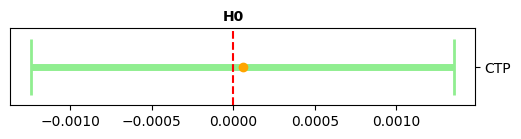

In [191]:
val = ctp.loc['CTP']
plot_ci_interval(observed=val["Observed"], 
                 error=val["error"], 
                 h_0=0, 
                 name='CTP')

## Проверка на практическую и статистическую значимость

Метрика является статистически значимой, если доверительный интервал не включает 0 (то есть вы можете быть уверены, что изменение было), и практически значимым, если доверительный интервал не включает границу практической значимости (то есть вы можете уверен, что есть изменение, которое имеет значение для бизнеса.)

In [81]:
effect_A = df_A.dropna()
effect_B  = df_B.dropna()

totals = pd.DataFrame({"A": effect_A .iloc[:, 2:].sum(), 
                       "B": effect_B.iloc[:, 2:].sum()})
totals

,A,B
Clicks,17293.0,17260.0
Enrollments,3785.0,3423.0
Payments,2033.0,1945.0


In [82]:
clicks_A, clicks_B = totals.loc["Clicks"]
enrollments_A, enrollments_B = totals.loc["Enrollments"]
payments_A, payments_B = totals.loc["Payments"]

effect = pd.DataFrame({"x_A": [enrollments_A, payments_A], 
                       "x_B": [enrollments_B, payments_B],
                       "n_A": [clicks_A, clicks_A], 
                       "n_B": [clicks_B, clicks_B]
                       }, 
                      index=["Валовая конверсия", "Чистая конверсия"])
effect["A"] = effect["x_A"] / effect["n_A"]
effect["B"] = effect["x_B"] / effect["n_B"]
effect["p_pool"] = (effect["x_A"] + effect["x_B"]) / (effect["n_A"] + effect["n_B"])
effect["se_pool"] = get_se_pool(effect["p_pool"], effect["n_A"], effect["n_B"])
effect["error"] = effect["se_pool"] * stats.norm.ppf(1-alpha/2)
effect["Observed"] = effect['B'] - effect['A']
effect["MDE"] = [0.01, 0.0075]
effect["CI_lower"] = effect["Observed"] - effect['error']
effect["CI_upper"] = effect["Observed"] + effect['error']
effect["Stat Significance"] = ((effect["CI_lower"] > 0) | (effect["CI_upper"] < 0))
effect["Practice Significance"] = (effect[["CI_lower", "CI_upper"]].abs().min(1) > effect["MDE"])
effect.round(4)

,x_A,x_B,n_A,n_B,A,B,p_pool,se_pool,error,Observed,MDE,CI_lower,CI_upper,Stat Significance,Practice Significance
Валовая конверсия,3785.0,3423.0,17293.0,17260.0,0.2189,0.1983,0.2086,0.0044,0.0086,-0.0206,0.0100,-0.0291,-0.0120,True,True
Чистая конверсия,2033.0,1945.0,17293.0,17260.0,0.1176,0.1127,0.1151,0.0034,0.0067,-0.0049,0.0075,-0.0116,0.0019,False,False


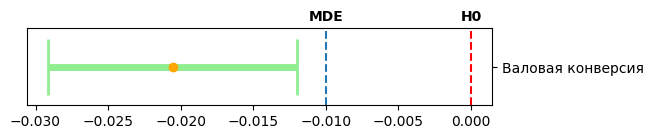

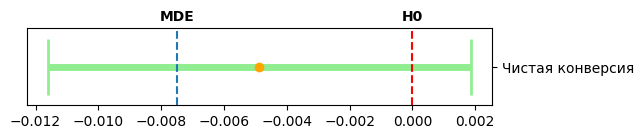

In [190]:
for metric in ["Валовая конверсия", "Чистая конверсия"]:
    val = effect.loc[metric]
    plot_ci_interval(observed=val["Observed"], 
                     error=val["error"], 
                     h_0=0, 
                     mde=val["MDE"], 
                     name=metric)

## Тест на направление эффекта

+ предполагая что конверсия рандомно колеблется в меньшую и большую сторону с верочтностью 50%, определим статисчическую значимость наблюдаемых знаков.
+ [калькулятор](https://www.graphpad.com/quickcalcs/binomial1.cfm)
+ `stats.binom.pmf(x, n, p)` - точечная биномиальная вероятность
+ `stats.binom.cdf(x, n, p)` - кумулятивная биномиальная вероятность

In [118]:
n = len(effect_A)

gross_conversion_A = effect_A["Enrollments"] /  effect_A["Clicks"]
gross_conversion_B = effect_B["Enrollments"] /  effect_B["Clicks"]

net_conversion_A = effect_A["Payments"] /  effect_A["Clicks"]
net_conversion_B = effect_B["Payments"] /  effect_B["Clicks"]

gross_sign = (gross_conversion_A < gross_conversion_B).sum()
net_sign = (net_conversion_A < net_conversion_B).sum()
print(f'Всего испытаний: {n}')
print(f'Валовая конверсия (A<B): {gross_sign}')
print(f'Чистая конверсия (A<B): {net_sign}')

Всего испытаний: 23
Валовая конверсия (A<B): 4
Чистая конверсия (A<B): 10


In [119]:
stats.binom.cdf(k=gross_sign, n=n, p=0.5) * 2

0.002599477767944336

In [120]:
stats.binom.cdf(k=net_sign, n=n, p=0.5) * 2

0.6776394844055176

Вывод: Валовая конверсия статистически значима, Чистая конверсия статистически не значима

# Рекомендации

Изменения не запускать в продакш, так как результаты эксперимента показали статистическую и практическую НЕ значимость изменения *Чистой конверсии*, а изменение *Валовой конверсии* оказалось статистически и практически значимым в негативную сторону (в принципе ожидаемо, так как измение отсеивало часть студентов)